# PREDICCIÓN DE LA PRODUCCIÓN DE ENERGÍA EÓLICA CON SCIKIT-LEARN


## Configuración previa

In [237]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        install(package)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [238]:
# definicion de constantes usadas a lo largo del proyecto
SEED = 100472050 # la semilla debe ser el NIA de uno de los integrantes
wind_ava = pd.read_csv("data/wind_ava.csv", index_col=0)
wind_comp = pd.read_csv("data/wind_comp.csv", index_col=0)

## EDA

### Seleccion de el molino 13 (sotavento)

In [239]:
# la variable objetivo es la columna energy y solo queremos los datos que
# terminan en 13, agregar la columna energy a wind_ava
aux = wind_ava[wind_ava.columns[wind_ava.columns.str.endswith('13')]]
# añadir la columna energy a wind_ava
aux.insert(0, "energy", wind_ava["energy"])     
wind_ava = aux
del aux

### Exploración inicial
 - Estructura.
 - Tipos.
 - Identificación de valores faltantes.

In [240]:
display(wind_ava.head())
print("TYPES:\n",wind_ava.dtypes)
display("NULLS:", wind_ava.isnull().sum())
# comprobar si hay columnas constantes
print(wind_ava.columns[wind_ava.nunique() == 1].tolist())

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114


TYPES:
 energy        float64
p54.162.13    float64
p55.162.13    float64
cape.13       float64
p59.162.13    float64
lai_lv.13     float64
lai_hv.13     float64
u10n.13       float64
v10n.13       float64
sp.13         float64
stl1.13       float64
u10.13        float64
v10.13        float64
t2m.13        float64
stl2.13       float64
stl3.13       float64
iews.13       float64
inss.13       float64
stl4.13       float64
fsr.13        float64
flsr.13       float64
u100.13       float64
v100.13       float64
dtype: object


'NULLS:'

energy        0
p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64

[]


Podemos observar que todos los datos son continuos, no hay NANs ni NULLS y no hay columnas constantes.

### Estadísticas descriptivas

In [241]:
display(wind_ava.describe())

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
count,4748.000000,4.748000e+03,4748.000000,4748.000000,4.748000e+03,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,...,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,693.126247,2.489477e+06,16.008810,31.166541,1.706692e+06,2.815222,2.576284,0.386215,0.120528,97820.301287,...,285.689253,286.663838,286.665988,0.074229,0.049971,286.668152,0.413677,-5.908467,0.447175,0.328204
std,665.531609,4.482599e+04,6.552216,121.758977,1.466953e+06,0.397377,0.116434,3.100583,3.016766,713.689654,...,6.163483,5.547947,4.582827,0.367013,0.379014,3.552873,0.007602,0.094359,4.841730,4.667552
min,0.010000,2.358748e+06,1.650268,0.000000,5.610341e+04,2.323973,2.425866,-8.619823,-8.867441,93770.364813,...,268.970603,275.461648,278.389271,-1.714897,-1.438829,280.875389,0.364805,-6.130465,-11.879053,-13.043453
25%,144.170000,2.458543e+06,11.203264,0.000000,6.563209e+05,2.425944,2.461630,-1.950008,-2.050920,97459.369264,...,281.458939,282.287394,282.689506,-0.126880,-0.148495,283.405549,0.410027,-5.977599,-3.836853,-3.256194
50%,465.305000,2.490478e+06,15.543441,1.004148,1.239176e+06,2.758857,2.560520,0.048820,-0.191853,97861.147677,...,285.395453,286.191880,286.204914,0.010551,-0.003569,286.591659,0.410917,-5.947220,0.282399,-0.389416
75%,1089.375000,2.525134e+06,20.214077,14.143328,2.296548e+06,3.205385,2.688526,2.641779,2.016289,98251.478418,...,289.740438,291.345311,290.989045,0.232378,0.172325,290.024705,0.417070,-5.858848,4.187953,3.614395
max,2792.550000,2.580387e+06,39.230807,2311.662152,1.110694e+07,3.450745,2.762992,12.974802,11.699814,99917.733093,...,305.000640,299.556292,295.639998,2.842552,2.366522,292.808658,0.428914,-5.618172,18.964137,16.913033


#### Busqueda de valores atipicos

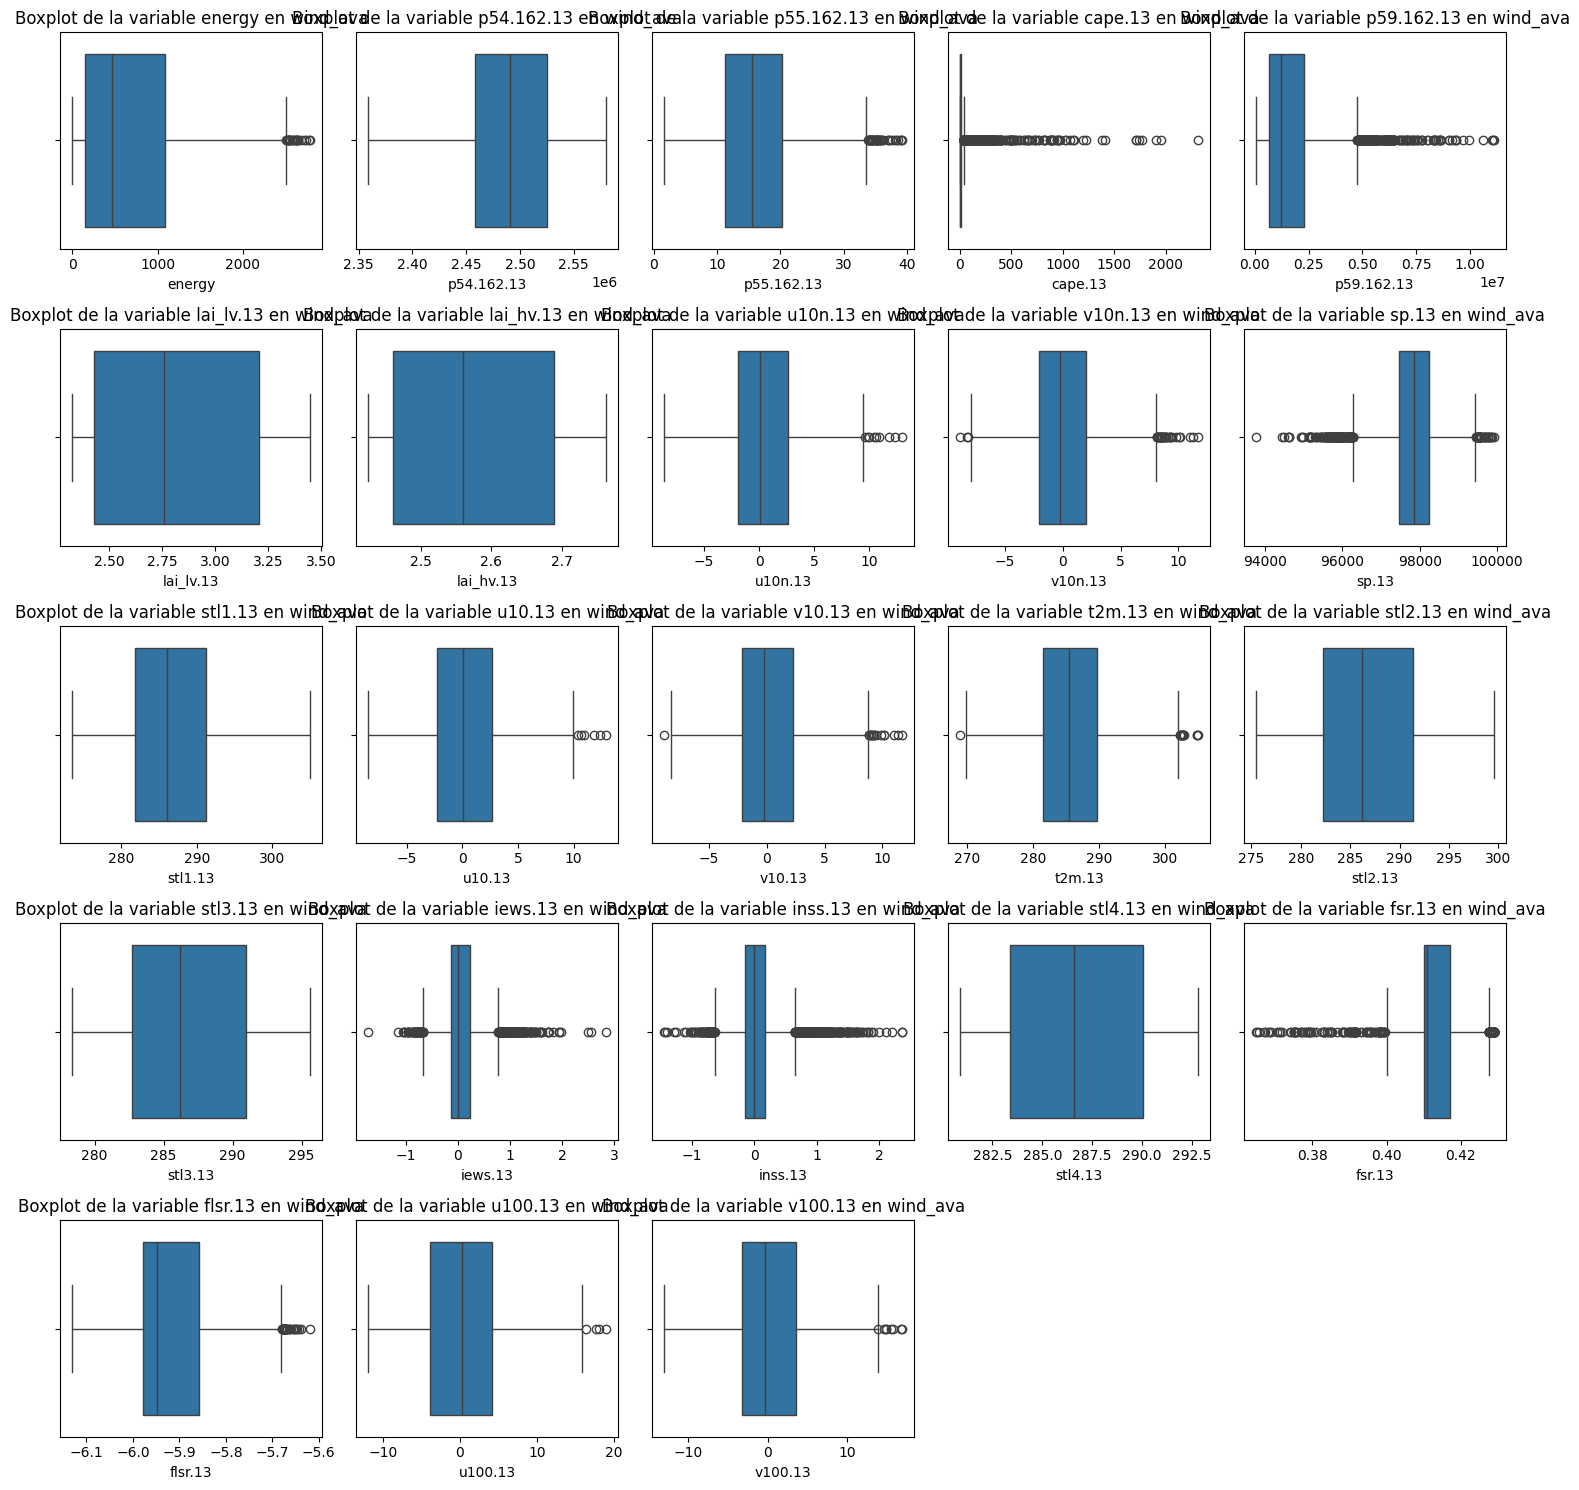

In [242]:
num_plots = len(wind_ava.columns)
num_rows = -(-num_plots // 5)  

fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

axs = axs.flatten() # Aplanar el array de ejes para facilitar el acceso

for i, column in enumerate(wind_ava.columns):
    sns.boxplot(x=wind_ava[column], ax=axs[i])
    axs[i].set_title(f"Boxplot de la variable {column} en wind_ava")

# Ocultar ejes sobrantes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### Analisis univariado

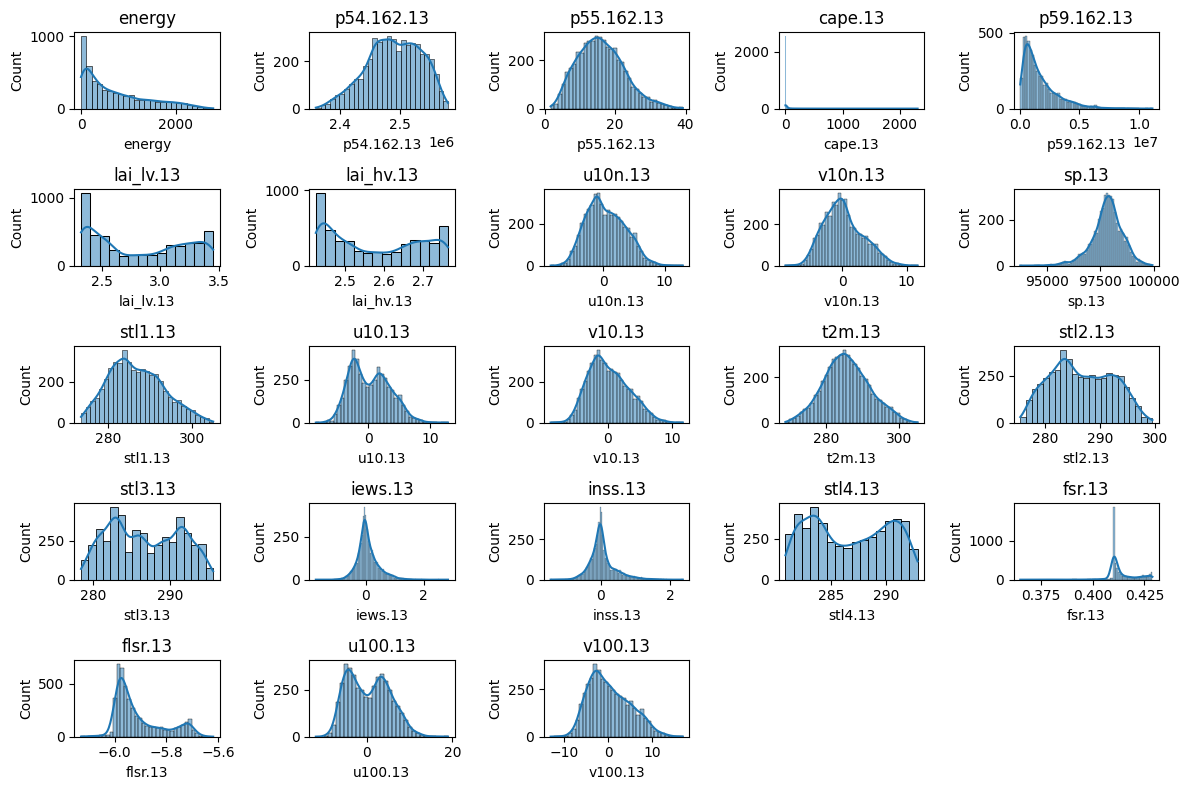

In [243]:
# Histogramas para cada variable
''' # Descomentar para ver los histogramas de las variables con outliers, son muy similares a los de las variables sin outliers.
plt.figure(figsize=(12, 8))
for i, column in enumerate(wind_ava.columns):
    plt.subplot(5, 5, i + 1)
    sns.histplot(wind_ava[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()
'''
plt.figure(figsize=(12, 8))
for i, column in enumerate(wind_ava.columns):
    plt.subplot(5, 5, i + 1)
    sns.histplot(wind_ava[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()


Lo mas relevante de estas graficas son, tanto los picos en 0 en cape y en fsr, que como tambien veremos mas adelante estan muy relacionados.
El hecho de que la distribucion de los valores de cape sea asi tambien hace pensar que podemos tener problemas en el futuro, ya que el modelo puede  predecir siempre cape=0 con una precision bastante alta.

### Analisis multivariado

#### Matrices de correalcion

Correlacion general

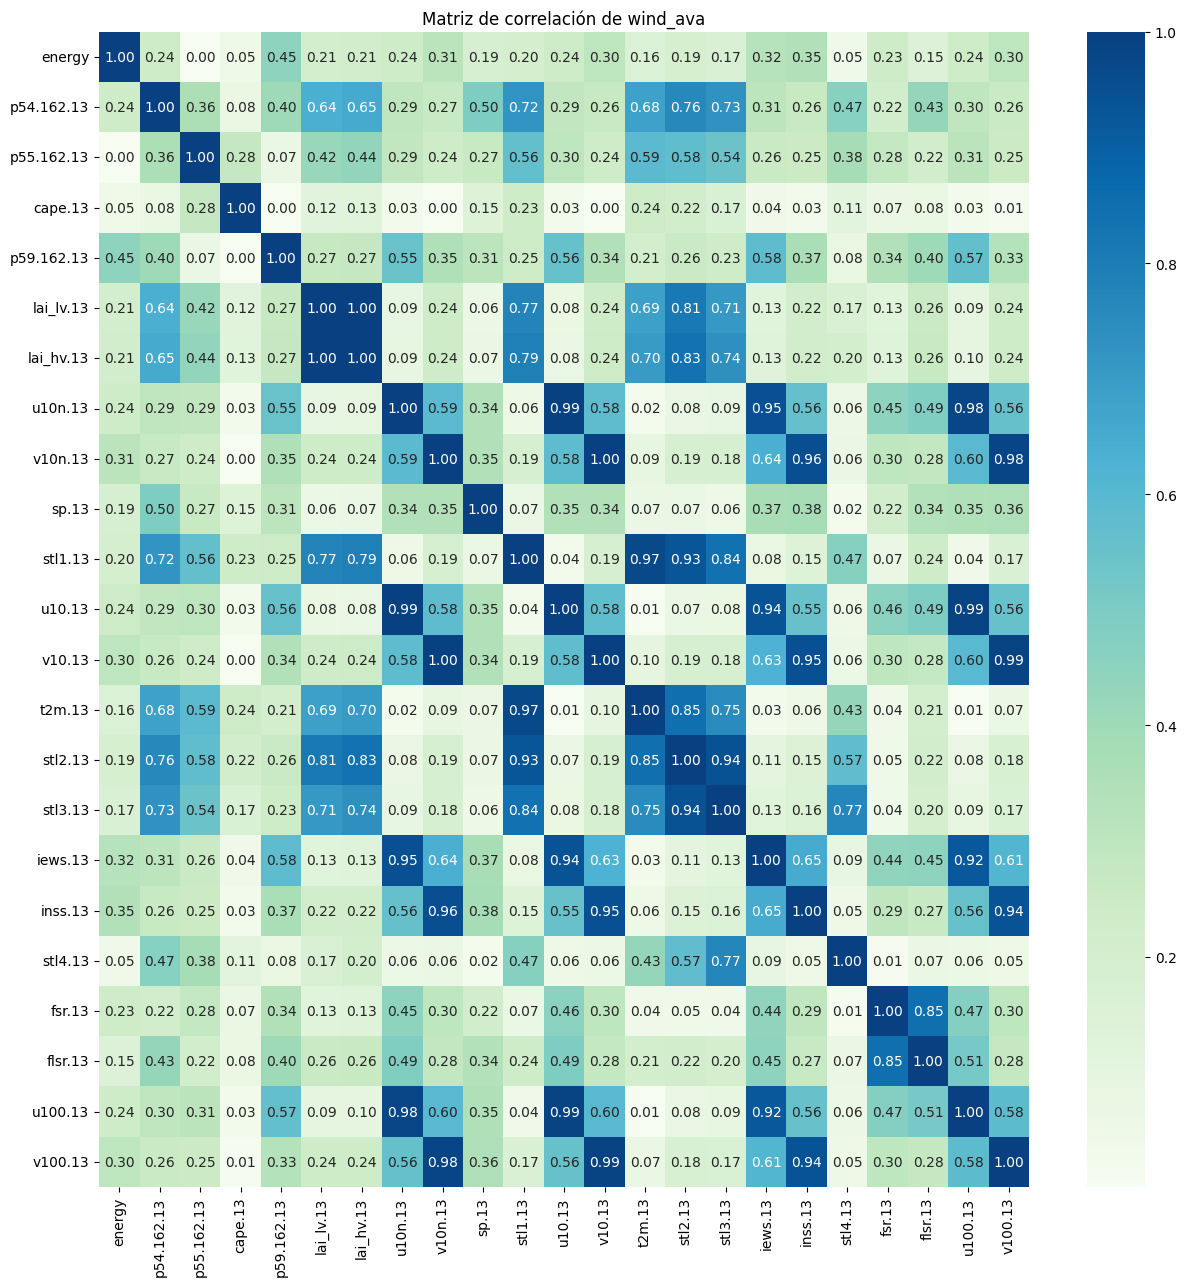

In [244]:
# correlacion entre las variables 
correlation = wind_ava.corr()
# poner correlaciones en valor absoluto
correlation = correlation.abs()
# mostrar la matriz de correlacion
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación de wind_ava")
plt.show()

Correlacion con la variable objetivo

Podemos ver que hay variables que estan muy altamente correlacionadas entre si, con correlaciones cercanas a 1, habra que decidir que hacer con estas variables ya que a priori no parecen muy utiles al aportar la misma información

#### Vamos a generar un nuevo df con las variables que tengan una correlacion menor a 0.9

Variables eliminadas: ['lai_lv.13', 'u10n.13', 't2m.13', 'v10.13', 'u100.13', 'v100.13', 'v10n.13']


,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_hv.13,sp.13,stl1.13,u10.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13
energy,1.000000,0.239832,0.000785,0.047995,0.446710,0.213400,0.191786,0.197850,0.244619,0.192833,0.165994,0.323979,0.345784,0.046865,0.232329,0.151233
p54.162.13,0.239832,1.000000,0.358850,0.076709,0.402154,0.654980,0.495013,0.723378,0.285728,0.764640,0.728684,0.306725,0.262744,0.466726,0.218215,0.427780
p55.162.13,0.000785,0.358850,1.000000,0.275533,0.066936,0.435308,0.265860,0.564382,0.304594,0.578362,0.543473,0.259277,0.253722,0.381961,0.279180,0.216079
cape.13,0.047995,0.076709,0.275533,1.000000,0.003355,0.128238,0.146495,0.233210,0.033782,0.215031,0.173513,0.042621,0.032277,0.113361,0.069333,0.075812
p59.162.13,0.446710,0.402154,0.066936,0.003355,1.000000,0.274646,0.305721,0.246174,0.558743,0.259624,0.234904,0.580297,0.370533,0.082973,0.343894,0.404736


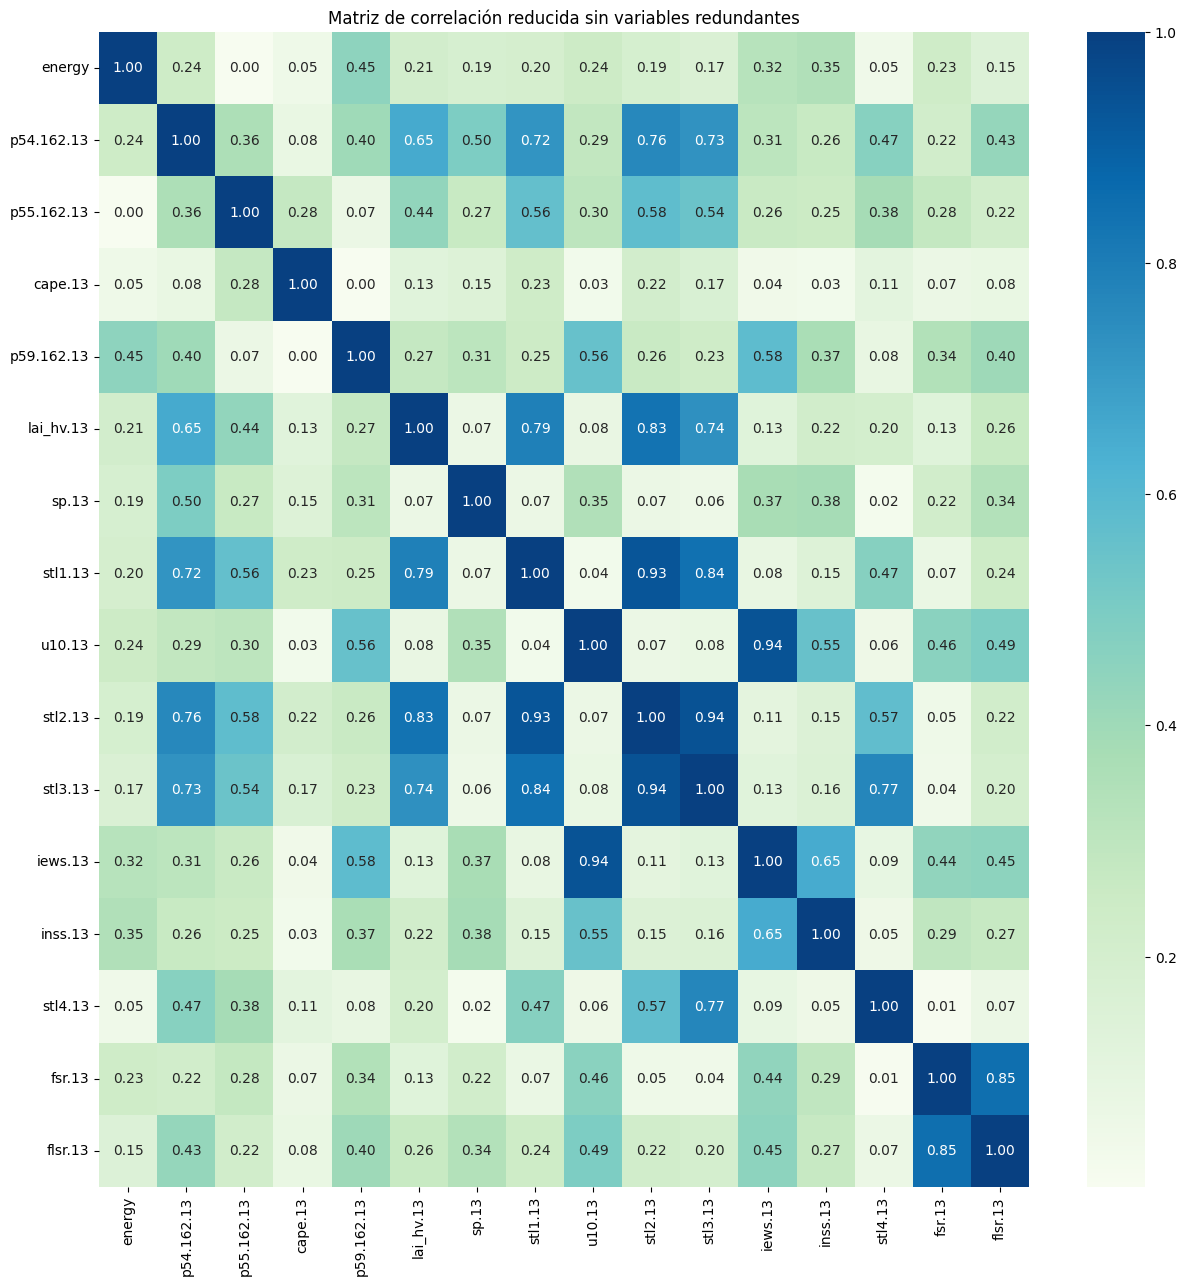

In [245]:

# Identificar pares de variables con correlación >= 0.9 (excluyendo la diagonal)
high_corr_pairs = (correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
                   .stack()
                   .where(lambda x: x >= 0.95)
                   .dropna())

energy_corr_with_vars = dict(correlation['energy'].drop('energy'))

# Determinar qué variables eliminar basándose en la correlación menor con 'energy'
vars_to_remove = []
for pair in high_corr_pairs.index:
    # Comparar la correlación de cada variable del par con 'energy'
    if energy_corr_with_vars[pair[0]] < energy_corr_with_vars[pair[1]]:
        vars_to_remove.append(pair[0])
    else:
        vars_to_remove.append(pair[1])

# Eliminar variables duplicadas en la lista de eliminación
vars_to_remove = list(set(vars_to_remove))

# Ahora, vamos a asegurarnos de que eliminamos correctamente las variables, incluso si hay correlaciones perfectas.
# Primero, crearemos una copia del DataFrame original para no modificar el existente mientras iteramos.
correlation_reduced = correlation.copy()

# Eliminaremos cada variable en vars_to_remove del DataFrame copiado.
for var in vars_to_remove:
    if var in correlation_reduced.columns:
        correlation_reduced.drop(var, axis=1, inplace=True)
        correlation_reduced.drop(var, axis=0, inplace=True)  # También eliminamos la fila para mantener la matriz cuadrada

wind_ava = wind_ava.drop(vars_to_remove, axis=1)

# Finalmente, mostraremos las variables que se han eliminado y la matriz de correlación reducida.
print(f"Variables eliminadas: {vars_to_remove}")
display(correlation_reduced.head())

# Mostrar la matriz de correlación reducida
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_reduced, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación reducida sin variables redundantes")
plt.show()


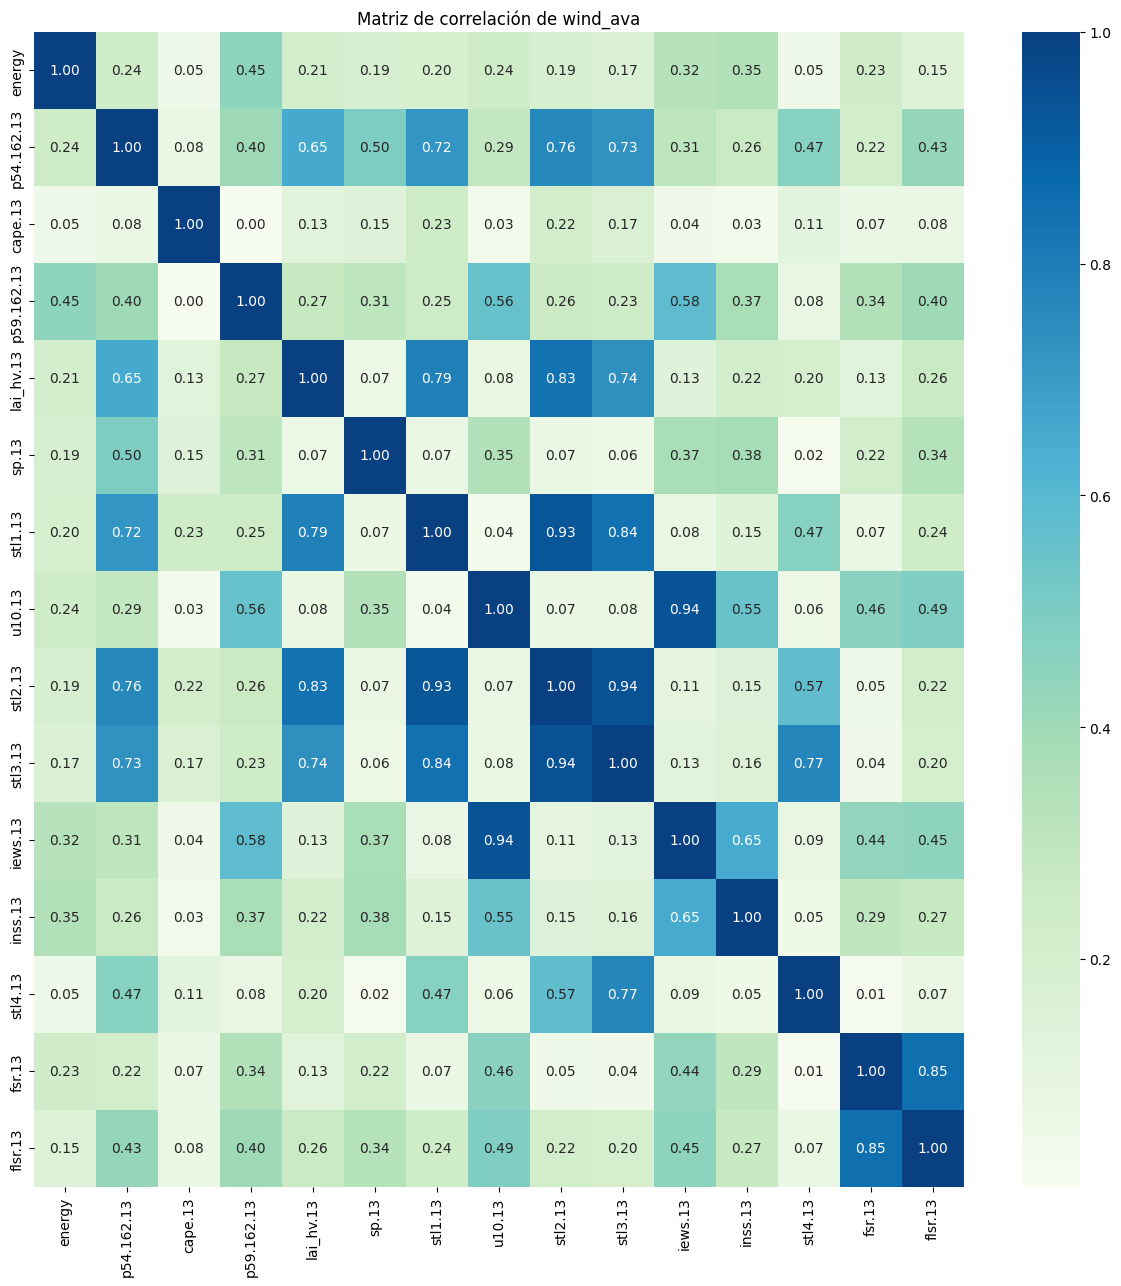

In [246]:
# Eliminamos las variables que tengan una correlación menor a 0.05 con la variable dependiente energy.
low_corr_vars = correlation_reduced['energy'][correlation_reduced['energy'] < 0.01].index
wind_ava = wind_ava.drop(low_corr_vars, axis=1)

# Volveremos a mostrar la matriz de correlación para verificar que las variables se han eliminado correctamente.
correlation = abs(wind_ava.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación de wind_ava")
plt.show()


## Sistemas de evaluación

### Evaluación Outer e Inner, seleccion de las medidas del Error

Como hemos podido observar en el EDA, los datos contienen una gran cantidad de datos atipicos, que podemos suponer que hay ruido en los datos, es por ello que vamos a descartar MSE como medida pues es muy probable que sobreestime el error.
Ademas los valores de cape.13 van desde 0 en la mayoria de casos a varios miles en otros, lo cual tambien es un problema con el MSE, por lo que podriamos plantearnos emplear MPSE, aun asi debido a los valores atipicos esta medida tampoco nos parece la ideal. 
Lo mismo ocurre aun que en menor medida con RMSE Y RMSPE.
Una medida que poriamos plantearnos usar es MAPE o MAE para solucionar este problema con los valores atipicos, pero nos introduce de nuevo conflicto con el gran rango de valores que toma cape.13.

Teniendo esto en cuenta consideramos que las mejores medidas del error para este caso son:
- R2
- **RMSE**

#### Creación de un modelo dummy

Basandonos en las medidas seleccionadas anteriormente vamos a crear un regresor dummy y evaluarlo.

In [247]:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Primero, dividiremos los datos en entrenamiento y test sin varaibles correlacionadas
X = wind_ava.drop(columns='energy')
y = wind_ava['energy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Entrenar un modelo de regresión "dummy" que prediga la media
# Este modelo es útil como referencia para comparar con otros modelos en el futuro
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

dummy_rmse = rmse(y_test, dummy.predict(X_test))
dummy_r2 = metrics.r2_score(y_test, dummy.predict(X_test))
dummy_mae = metrics.mean_absolute_error(y_test, dummy.predict(X_test))

print(f"RMSE del modelo dummy: {dummy_rmse:.2f}")
print(f"R^2 del modelo dummy: {dummy_r2:.2f}")
print(f"MAE del modelo dummy: {dummy_mae:.2f}")

RMSE del modelo dummy: 664.42
R^2 del modelo dummy: -0.00
MAE del modelo dummy: 550.78


Como se puede observar, haciendo uso de dos modelos de regresión "dummy" se tiene a un error cuadrático medio elevado.
Este modelo lo usaremos para comparar con nuestro modelo real

## Metodo de Escalado con KNN

In [248]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#normalizacion por escala min-max
min_max = make_column_transformer(
    (MinMaxScaler(), X_train.columns)
)

#normalizacion por escala estandar
standard = make_column_transformer(
    (StandardScaler(), X_train.columns)
)


### Escalado min-max

In [249]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import time

pipe_knn = Pipeline([
        ('preproceso', min_max), #entrada del pipeline
        ('regresor', KNeighborsRegressor()) #salida del pipeline
])

np.random.seed(SEED)

t1 = time.time()
pipe_knn.fit(X_train, y_train)
t2 = time.time()

y_test_pred = pipe_knn.predict(X_test)

rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")
print("Tiempo de entrenamiento: ", t2 - t1)

RMSE: 447.1772359279531
R2: 0.5470278963931176
Tiempo de entrenamiento:  0.011532068252563477


### Escalado estandar

In [250]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import time

pipe_knn = Pipeline([
        ('preproceso', standard), #entrada del pipeline
        ('regresor', KNeighborsRegressor()) #salida del pipeline
])

np.random.seed(SEED)

t1 = time.time()
pipe_knn.fit(X_train, y_train)
t2 = time.time()

y_test_pred = pipe_knn.predict(X_test)

rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")
print("Tiempo de entrenamiento: ", t2 - t1)

RMSE: 398.08190631136785
R2: 0.6410309884708905
Tiempo de entrenamiento:  0.010584831237792969


El escalado min-max es el que mejor se ajusta a los datos, por lo que lo usaremos en el resto del notebook

## A continuación, se considerarán estos métodos: KNN, árboles de regresión, regresión lineal (la normal y al menos, la variante Lasso) y SVM:
a.	Se evaluarán dichos modelos con sus hiperparámetros por omisión. También se medirán los tiempos que tarda el entrenamiento.

b.	Después, se ajustarán los hiperparámetros más importantes de cada método y se obtendrá su evaluación. Medir tiempos del entrenamiento, ahora con HPO.

c.	Obtener algunas conclusiones, tales como: ¿cuál es el mejor método? ¿Cuál de los métodos básicos de aprendizaje automático es más rápido? ¿Los resultados son mejores que los regresores triviales/naive/dummy? ¿El ajuste de hiperparámetros mejora con respecto a los valores por omisión? ¿Hay algún equilibrio entre tiempo de ejecución y mejora de resultados? ¿Es posible extraer de alguna técnica qué atributos son más relevantes? etc.



### Evaluacion de los modelos con los parametros por defecto

#### KNN

In [251]:
# regresor knn con parametros por defecto 
from sklearn.neighbors import KNeighborsRegressor

pipe_knn = Pipeline([
        ('preproceso', standard),
        ('regresor', KNeighborsRegressor())
])

# Entrenar el modelo
t1 = time.time()
pipe_knn.fit(X_train, y_train)
t2 = time.time()

dt_knn = t2 - t1 

# Predecir los valores de test
y_test_pred = pipe_knn.predict(X_test)

# Calcular métricas
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")

RMSE: 398.08190631136785
R2: 0.6410309884708905


#### Arboles de regresion

In [252]:
# arbol de regresion con parametros por defecto
from sklearn.tree import DecisionTreeRegressor

pipe_tree = Pipeline([
        ('preproceso', standard),
        ('regresor', DecisionTreeRegressor())
])

# Entrenar el modelo
t1 = time.time()
pipe_tree.fit(X_train, y_train)
t2 = time.time()

dt_tree = t2 - t1

# Predecir los valores de test
y_test_pred = pipe_tree.predict(X_test)

# Calcular métricas
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_tree}")
print(f"R2: {r2_tree}")

RMSE: 516.1232259819354
R2: 0.3965811280822864


#### Regresion lineal

In [253]:
# regresion lineal con parametros por defecto
from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline([
        ('preproceso', standard),
        ('regresor', LinearRegression())
])

# Entrenar el modelo
t1 = time.time()
pipe_lr.fit(X_train, y_train)
t2 = time.time()

dt_lr = t2 - t1
# Predecir los valores de test
y_test_pred = pipe_lr.predict(X_test)

# Calcular métricas
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lr = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_lr}")
print(f"R2: {r2_lr}")

RMSE: 563.7533723817137
R2: 0.2800698064721735


#### Regresion Lasso

In [254]:
# regresor lasso con parametros por defecto
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline([
        ('preproceso', standard),
        ('regresor', Lasso(max_iter=10000))
])

# Entrenar el modelo
t1 = time.time()
pipe_lasso.fit(X_train, y_train)
t2 = time.time()

dt_lasso = t2 - t1
# Predecir los valores de test
y_test_pred = pipe_lasso.predict(X_test)

# Calcular métricas
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_lasso}")
print(f"R2: {r2_lasso}")

RMSE: 563.4977376636507
R2: 0.2807225650530074


#### SVM

In [255]:
# SVM con parametros por defecto
from sklearn.svm import SVR

pipe_svm = Pipeline([
        ('preproceso', standard),
        ('regresor', SVR())
])

# Entrenar el modelo
t1 = time.time()
pipe_svm.fit(X_train, y_train)
t2 = time.time()

dt_svm = t2 - t1

# Predecir los valores de test
y_test_pred = pipe_svm.predict(X_test)

# Calcular métricas
rmse_svm = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_svm}")
print(f"R2: {r2_svm}")


RMSE: 644.4361720891939
R2: 0.059255038543572947


#### Random Forest

In [256]:
# random forest con parametros por defecto
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
        ('preproceso', standard),
        ('regresor', RandomForestRegressor(random_state=SEED))
])

# Entrenar el modelo
t1 = time.time()
pipe_rf.fit(X_train, y_train)
t2 = time.time()

dt_rf = t2 - t1

# Predecir los valores de test
y_test_pred = pipe_rf.predict(X_test)

# Calcular métricas
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_rf = metrics.r2_score(y_test, y_test_pred)
print(f"RMSE: {rmse_rf}")
print(f"R2: {r2_rf}")

RMSE: 376.5162769295886
R2: 0.6788709506560119


### Evaluacion de los modelos con los hiperparametros ajustados
Usando RMSE para la evaluacion interna y RMSE y R2 para la externa

#### KNN

In [257]:
# ajuste de hiperparametros para knn basandonos en rmse

from sklearn.model_selection import GridSearchCV

param_grid = {
    'regresor__n_neighbors': range(1, 21),
    'regresor__weights': ['uniform', 'distance'],
    'regresor__p': [1, 2]
}

grid_search = GridSearchCV(pipe_knn, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()
dt_knn_hpo = t2 - t1

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_knn_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_knn_hpo}")
print(f"R2: {r2_knn_hpo}")


Mejores hiperparámetros encontrados:
{'regresor__n_neighbors': 10, 'regresor__p': 1, 'regresor__weights': 'distance'}
Evaluacion externa:
RMSE: 397.62120838125867
R2: 0.641861373290944


#### Arboles de regresion

In [258]:
# ajuste de hiperparametros para arbol de regresion basandonos en rmse

param_grid = {
    'regresor__max_depth': range(1, 11),
    'regresor__min_samples_split': range(2, 11),
    'regresor__min_samples_leaf': range(1, 11)
}

grid_search = GridSearchCV(pipe_tree, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()

dt_tree_hpo = t2 - t1

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_tree_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_tree_hpo}")
print(f"R2: {r2_tree_hpo}")

Mejores hiperparámetros encontrados:
{'regresor__max_depth': 7, 'regresor__min_samples_leaf': 10, 'regresor__min_samples_split': 3}
Evaluacion externa:
RMSE: 428.18407137769026
R2: 0.5846893223268999


#### Regresion lineal

In [259]:
# ajuste de hiperparametros para regresion lineal basandonos en rmse

param_grid = {
    'regresor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()
dt_regresion_lineal_hpo = t2 - t1

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_lr_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lr_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_lr_hpo}")
print(f"R2: {r2_lr_hpo}")


Mejores hiperparámetros encontrados:
{'regresor__fit_intercept': True}
Evaluacion externa:
RMSE: 563.7533723817137
R2: 0.2800698064721735


#### Regresion Lasso

In [260]:
# ajuste de hiperparametros para lasso basandonos en rmse
 
param_grid = {
    'regresor__alpha': np.logspace(-4, 4, 9)
}

grid_search = GridSearchCV(pipe_lasso, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()

dt_laso_hpo = t2 - t1

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_lasso_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_lasso_hpo}")
print(f"R2: {r2_lasso_hpo}")


Mejores hiperparámetros encontrados:
{'regresor__alpha': 1.0}
Evaluacion externa:
RMSE: 563.4977376636507
R2: 0.2807225650530074


#### SVM

In [261]:
# ajuste de hiperparametros para svm basandonos en rmse

param_grid = {
    'regresor__C': np.logspace(-4, 4, 9),
    'regresor__gamma': np.logspace(-4, 4, 9)
}

grid_search = GridSearchCV(pipe_svm, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()

dt_svm_hpo = t2 - t1

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_svm_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_svm_hpo}")
print(f"R2: {r2_svm_hpo}")


Mejores hiperparámetros encontrados:
{'regresor__C': 1000.0, 'regresor__gamma': 0.1}
Evaluacion externa:
RMSE: 375.7829862614966
R2: 0.6801205732731741


#### Random Forest

In [262]:
# ajuste de hiperparametros para random forest basandonos en rmse

param_grid = {
    'regresor__n_estimators': [150, 200],
    'regresor__max_depth': [20, None],
    'regresor__min_samples_split': [4, 7, 10],
    'regresor__min_samples_leaf': [2, 4],
    'regresor__bootstrap': [True]
}

grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# medir tiempo de entrenamiento
t1 = time.time()
grid_search.fit(X_train, y_train)
t2 = time.time()
dt_random_forest_hpo = t2 - t1
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Evaluacion externa:")
rmse_rf_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_rf_hpo = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_rf_hpo}")
print(f"R2: {r2_rf_hpo}")

Mejores hiperparámetros encontrados:
{'regresor__bootstrap': True, 'regresor__max_depth': None, 'regresor__min_samples_leaf': 2, 'regresor__min_samples_split': 4, 'regresor__n_estimators': 200}
Evaluacion externa:
RMSE: 372.6573128448989
R2: 0.6854198041975718


Habiendo obtenido los resultados de los modelos con los hiperparametros ajustados, vamos a compararlos con los resultados obtenidos con los hiperparametros por defecto para distinguir qué modelo será empleado en la predicción de la producción de energía.

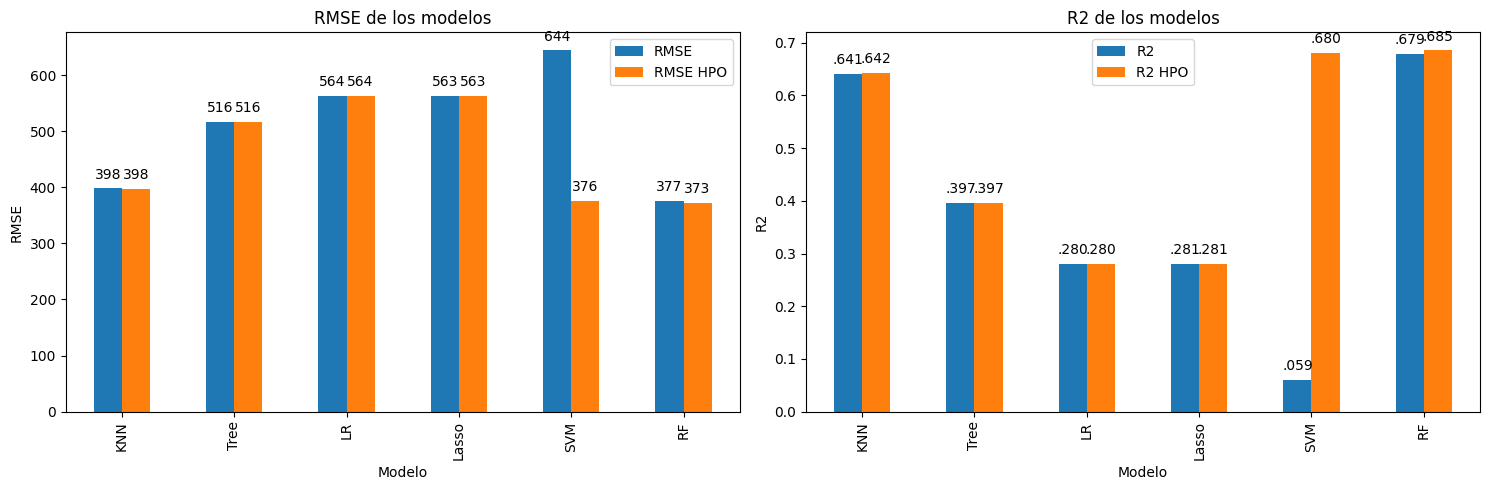

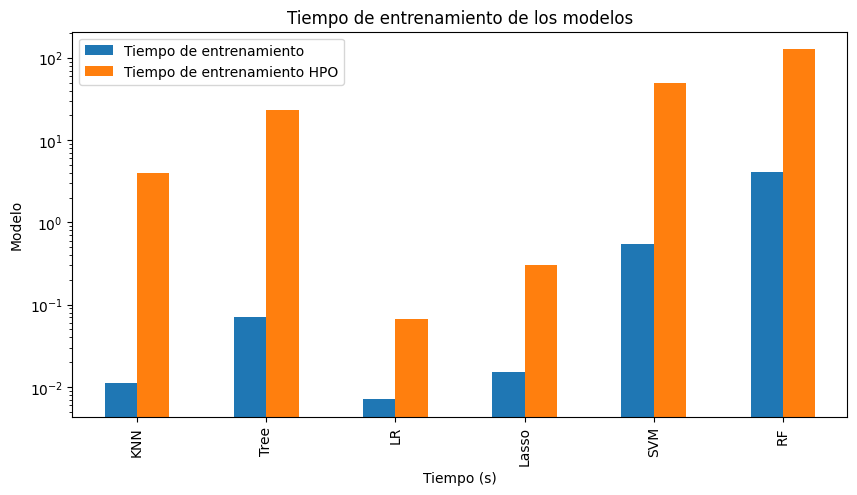

In [263]:
# Graficaremos los resultados de los modelos con los hiperparametros ajustados y los hiperparametros por defecto

# RMSE
rmse = [rmse_knn, rmse_tree, rmse_lr, rmse_lasso, rmse_svm, rmse_rf]
rmse_hpo = [rmse_knn_hpo, rmse_tree, rmse_lr_hpo, rmse_lasso_hpo, rmse_svm_hpo, rmse_rf_hpo]

# R2
r2 = [r2_knn, r2_tree, r2_lr, r2_lasso, r2_svm, r2_rf]
r2_hpo = [r2_knn_hpo, r2_tree, r2_lr_hpo, r2_lasso_hpo, r2_svm_hpo, r2_rf_hpo]

# tiempos
tiempos = [dt_knn, dt_tree, dt_lr, dt_lasso, dt_svm, dt_rf]
tiempos_hpo = [dt_knn_hpo, dt_tree_hpo, dt_regresion_lineal_hpo, dt_laso_hpo, dt_svm_hpo, dt_random_forest_hpo]


# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'RMSE': rmse,
    'RMSE HPO': rmse_hpo,
    'R2': r2,
    'R2 HPO': r2_hpo,
}, index=['KNN', 'Tree', 'LR', 'Lasso', 'SVM', 'RF'])

# Graficar los resultados
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

results[['RMSE', 'RMSE HPO']].plot(kind='bar', ax=axs[0])
axs[0].set_title('RMSE de los modelos')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Modelo')
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

results[['R2', 'R2 HPO']].plot(kind='bar', ax=axs[1])
axs[1].set_title('R2 de los modelos')
axs[1].set_ylabel('R2')
axs[1].set_xlabel('Modelo')
for p in axs[1].patches:
    axs[1].annotate(format(p.get_height(), '.3f').lstrip('0'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Graficar los tiempos de entrenamiento en horizontal, azul para los modelos con hiperparámetros por defecto y naranja para los modelos con hiperparámetros ajustados
time_results = pd.DataFrame({
    'Tiempo de entrenamiento': tiempos,
    'Tiempo de entrenamiento HPO': tiempos_hpo,
}, index=['KNN', 'Tree', 'LR', 'Lasso', 'SVM', 'RF'])

ax = time_results.plot(kind='bar', figsize=(10, 5))
plt.title('Tiempo de entrenamiento de los modelos')
ax.set_yscale('log')
plt.xlabel('Tiempo (s)')
plt.ylabel('Modelo')
plt.show()

Como se puede observar, los modelos más prometedores son el Random Forest y el SVM, destacando éste último en el significativo cambio del error con el ajuste de hiperparámetros. No obstante, el mejor modelo es el Random Forest, ya que tiene un menor error y un mayor R2.

### Selección del mejor modelo
Hemos seleccinado random forest por que a pesar de tardar mas en entrenarse es el mejor modelo en cuanto a error y R2.
Para la optimización de los hiperparámetros ibamos a usar un gridsearch, pero debido a la cantidad de datos y a la cantidad de hiperparámetros que tiene el modelo era inviable (60-100 horas).
Despues consideramos usar un randomsearch, pero los resultados obtenidos no eran satisfactorios.
Es por ello que hemos decidido utilizar optuna, que es una libreria que nos permite optimizar los hiperparámetros de una forma mas eficiente mediante una busqueda bayesiana, sin embargo sigue siendo un proceso lento, aproximadamente 7h, por lo que lo hemos ejecutado y anotado los resultados para no necesitar recalcularlo. Si se quiere replicar el proceso hay que descomentar las lineas que se señalan en el codigo y ejecutarlo.

In [264]:
try:
    import optuna
except ImportError:
    %pip install optuna
    import optuna

standard = make_column_transformer(
    (StandardScaler(), X_train.columns)
)



def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 350),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap':  trial.suggest_categorical('bootstrap', [True])
    }
    # print(f"Trial {trial.number} - Iniciando entrenamiento con hiperparámetros: {params}")
    
    model = Pipeline([
        ('standard', standard),
        ('rf', RandomForestRegressor(**params, random_state=SEED))
    ])
    
    rmse_scores = []
    for _ in range(5):  # 10-fold cross-validation
        X_fold_train, X_fold_val, y_fold_train, y_fold_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True)
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        rmse = metrics.root_mean_squared_error(y_fold_val, y_pred)
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)


def progress_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")
    print(f"Best trial so far: {study.best_trial.number}")

# study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# print("Iniciando búsqueda de hiperparámetros...")
# study.optimize(objective, n_trials=100, n_jobs=-1, callbacks=[progress_callback], show_progress_bar=True)

# best_params = study.best_params

best_params = {'n_estimators': 217, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}
print("Mejores hiperparámetros encontrados:")
print(best_params)

Mejores hiperparámetros encontrados:
{'n_estimators': 217, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}


In [265]:
# Entrenar el mejor modelo con los mejores hiperparámetros
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

best_model = Pipeline([
    ('preproceso', standard),
    ('regresor', RandomForestRegressor(**best_params, random_state=SEED))
])
t1 = time.time()
best_model.fit(X_train, y_train)
t2 = time.time()
dt = t2 - t1
# Predecir los valores de test
y_test_pred = best_model.predict(X_test)

# Calcular métricas
rmse_rf_cv = metrics.root_mean_squared_error(y_test, y_test_pred)
r2_rf_cv = best_model.score(X_test, y_test)
print(f"RMSE: {rmse_rf_cv}")
print(f"R2: {r2_rf_cv}")
print("Tiempo de entrenamiento: ", dt)

RMSE: 372.79947464598723
R2: 0.6851797454849267
Tiempo de entrenamiento:  7.948848485946655


In [266]:
# entrenar con los mejores hiperparametros encontrados y todos los datos
best_model.fit(X, y)

Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['p54.162.13', 'cape.13', 'p59.162.13', 'lai_hv.13', 'sp.13', 'stl1.13',
       'u10.13', 'stl2.13', 'stl3.13', 'iews.13', 'inss.13', 'stl4.13',
       'fsr.13', 'flsr.13'],
      dtype='object'))])),
                ('regresor',
                 RandomForestRegressor(max_depth=27, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=217,
                                       random_state=100472050))])

In [267]:
# exportar el modelo en un archivo pickle
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

### Medir la precision del modelo en energy alto y energy bajo

In [268]:
# Medir la precision del modelo en energy alto y energy bajo
# dividir el conjunto de datos en dos, uno con energy alto y otro con energy bajo
# cuando la energía sea menor que el tercer cuantil, se considerará clase “baja”, y 
# cuando sea mayor, clase  “alta”.
low_energy = wind_ava[wind_ava['energy'] < wind_ava['energy'].quantile(1/3)]
high_energy = wind_ava[wind_ava['energy'] > wind_ava['energy'].quantile(2/3)]

X_low = low_energy.drop(columns='energy')
y_low = low_energy['energy']

X_high = high_energy.drop(columns='energy')
y_high = high_energy['energy']

# medir el rendimiento en el conjunto de datos con energía baja
y_low_pred = best_model.predict(X_low)
rmse_low = metrics.root_mean_squared_error(y_low, y_low_pred)
r2_low = best_model.score(X_low, y_low)

# medir el rendimiento en el conjunto de datos con energía alta
y_high_pred = best_model.predict(X_high)
rmse_high = metrics.root_mean_squared_error(y_high, y_high_pred)
r2_high = best_model.score(X_high, y_high)

print(f"RMSE en energía baja: {rmse_low}")
print(f"R2 en energía baja: {r2_low}")

print(f"RMSE en energía alta: {rmse_high}")
print(f"R2 en energía alta: {r2_high}")


RMSE en energía baja: 116.79872385603124
R2 en energía baja: -1.7246752746291438
RMSE en energía alta: 221.97758515592818
R2 en energía alta: 0.7754215218040226


### Convertir el problema en uno de clasificacion
Cuando la energía sea menor que el tercer cuartil, se considerará clase "baja" y cuando sea mayor, clase "alta". El problema se resolverá 
usando algún método de clasificación. 

In [269]:
wind_ava_class = wind_ava.copy()
wind_ava_class['energy_class'] = 1
wind_ava_class.loc[wind_ava['energy'] < wind_ava_class['energy'].quantile(1/3), 'energy_class'] = 0
# eliminar la columna energy
wind_ava_class.drop(columns='energy', inplace=True)

wind_ava_class.head()


,p54.162.13,cape.13,p59.162.13,lai_hv.13,sp.13,stl1.13,u10.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,energy_class
datetime,,,,,,,,,,,,,,,
2005-01-02 18:00:00,2.510824e+06,13.527577,1.386937e+06,2.432983,99846.319914,280.960661,-0.906454,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,1
2005-01-03 00:00:00,2.513173e+06,6.896412,1.153526e+06,2.432838,99917.733093,279.296651,-1.653843,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,1
2005-01-03 06:00:00,2.509627e+06,4.774439,1.098754e+06,2.432704,99764.378681,278.233956,-2.580356,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,1
2005-01-03 12:00:00,2.510571e+06,0.000000,1.076021e+06,2.432514,99672.670459,280.787263,-3.365262,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,1
2005-01-03 18:00:00,2.505664e+06,0.000000,1.070830e+06,2.432369,99372.811211,279.583112,-2.242707,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,1


### Evaluación de modelos para Clasificación
Probaremos los siguientes modelos para convertir el problema en uno de clasificación: 
- KNN
- Random Forest
- SVC
- XGBoost

In [270]:
# Crearemos primero un clasificador dummy que prediga la clase mayoritaria
from sklearn.dummy import DummyClassifier

X = wind_ava_class.drop(columns='energy_class')
y = wind_ava_class['energy_class']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, test_size=0.2, random_state=SEED)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_class, y_train_class)

y_test_pred = dummy.predict(X_test_class)

accuracy_dummy = metrics.accuracy_score(y_test_class, y_test_pred)
print(f"Accuracy del clasificador dummy: {accuracy_dummy}")

f1_dummy = metrics.f1_score(y_test_class, y_test_pred)
print(f"F1 del clasificador dummy: {f1_dummy}")

Accuracy del clasificador dummy: 0.671578947368421
F1 del clasificador dummy: 0.8035264483627204


### Evaluacion de modelos con hiperparametros por defecto

#### KNN

In [271]:
# Probaremos un modelo KNN para clasificar la energía en alta o baja
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

pipe_knn = Pipeline([
    ('preproceso', standard),
    ('clasificador', KNeighborsClassifier())
])

pipe_knn.fit(X_train_class, y_train_class)

y_test_pred = pipe_knn.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_knn = accuracy_score(y_test_class, y_test_pred)
f1_knn = f1_score(y_test_class, y_test_pred)

print(f"Accuracy KNN: {accuracy_knn}")
print(f"F1-score KNN: {f1_knn}")

Accuracy KNN: 0.7789473684210526
F1-score KNN: 0.8364485981308412


#### Random Forest

In [272]:
# Probaremos un modelo Random Forest para clasificar la energía en alta o baja
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('preproceso', standard),
    ('clasificador', RandomForestClassifier(random_state=SEED))
])

pipe_rf.fit(X_train_class, y_train_class)

y_test_pred = pipe_rf.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_rf = accuracy_score(y_test_class, y_test_pred)
f1_rf = f1_score(y_test_class, y_test_pred)

print(f"Accuracy RF: {accuracy_rf}")
print(f"F1-score RF: {f1_rf}")

Accuracy RF: 0.8052631578947368
F1-score RF: 0.8567002323780015


#### SVC

In [273]:
# Probaremos un modelo SVC para clasificar la energía en alta o baja
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ('preproceso', standard),
    ('clasificador', SVC())
])

pipe_svc.fit(X_train_class, y_train_class)

y_test_pred = pipe_svc.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_svc = accuracy_score(y_test_class, y_test_pred)
f1_svc = f1_score(y_test_class, y_test_pred)

print(f"Accuracy SVC: {accuracy_svc}")
print(f"F1-score SVC: {f1_svc}")

Accuracy SVC: 0.8031578947368421
F1-score SVC: 0.8537920250195465


#### XGBoost

In [274]:
# Probaremos un modelo XGBoost para clasificar la energía en alta o baja
try:
    from xgboost import XGBClassifier
except ImportError:
    %pip install xgboost
    from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ('preproceso', standard),
    ('clasificador', XGBClassifier())
])

pipe_xgb.fit(X_train_class, y_train_class)

y_test_pred = pipe_xgb.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_xgb = accuracy_score(y_test_class, y_test_pred)
f1_xgb = f1_score(y_test_class, y_test_pred)

print(f"Accuracy XGB: {accuracy_xgb}")
print(f"F1-score XGB: {f1_xgb}")


Accuracy XGB: 0.8084210526315789
F1-score XGB: 0.8584758942457231


#### Regresion logistica

In [275]:
# regresion logistica con parametros por defecto
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
        ('preproceso', standard),
        ('clasificador', LogisticRegression())
])

# Entrenar el modelo
pipe_lr.fit(X_train_class, y_train_class)

# Predecir los valores de test
y_test_pred = pipe_lr.predict(X_test_class)

# Calcular métricas
accuracy_lr = accuracy_score(y_test_class, y_test_pred)
f1_lr = f1_score(y_test_class, y_test_pred)

print(f"Accuracy LR: {accuracy_lr}")
print(f"F1-score LR: {f1_lr}")

Accuracy LR: 0.7357894736842105
F1-score LR: 0.8174545454545454


### Evaluacion de modelos con hiperparametros ajustados

#### KNN

In [276]:
# Probaremos un modelo KNN para clasificar la energía en alta o baja 
# con hiperparámetros ajustados

param_grid = {
    'clasificador__n_neighbors': range(30, 100),
    'clasificador__weights': ['uniform', 'distance'],
    'clasificador__p': [1, 2]
}

grid_search = GridSearchCV(pipe_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_class, y_train_class)

best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
y_test_pred = best_model.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_knn_hpo = accuracy_score(y_test_class, y_test_pred)
f1_knn_hpo = f1_score(y_test_class, y_test_pred)

print(f"Accuracy KNN HPO: {accuracy_knn_hpo}")
print(f"F1-score KNN HPO: {f1_knn_hpo}")

Mejores hiperparámetros encontrados:
{'clasificador__n_neighbors': 32, 'clasificador__p': 1, 'clasificador__weights': 'distance'}
Accuracy KNN HPO: 0.8063157894736842
F1-score KNN HPO: 0.8591117917304747


#### Random Forest

In [277]:
# Probaremos un modelo Random Forest para clasificar la energía en alta o baja 
# con hiperparámetros ajustados


param_grid = {
    'clasificador__n_estimators': range(150, 250, 25),
    'clasificador__max_depth': [20, None],
    'clasificador__min_samples_split': [5, 10],
    'clasificador__min_samples_leaf': [2, 4],
    'clasificador__bootstrap': [True]
}
pipe_rf = Pipeline([
    ('preproceso', standard),
    ('clasificador', RandomForestClassifier(random_state=SEED))
])


grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_class, y_train_class)

best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Calcular métricas
y_test_pred = best_model.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_rf_hpo = accuracy_score(y_test_class, y_test_pred)
f1_rf_hpo = f1_score(y_test_class, y_test_pred)

print(f"Accuracy RF HPO: {accuracy_rf_hpo}")
print(f"F1-score RF HPO: {f1_rf_hpo}")

Mejores hiperparámetros encontrados:
{'clasificador__bootstrap': True, 'clasificador__max_depth': None, 'clasificador__min_samples_leaf': 2, 'clasificador__min_samples_split': 5, 'clasificador__n_estimators': 150}
Accuracy RF HPO: 0.8010526315789473
F1-score RF HPO: 0.852689010132502


In [278]:
best_model = RandomForestClassifier(**best_params, random_state=SEED)
pipe_rf = Pipeline([
    ('preproceso', standard),
    ('clasificador', best_model)
])

pipe_rf.fit(X_train_class, y_train_class)

y_test_pred = pipe_rf.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_rf_hpo = accuracy_score(y_test_class, y_test_pred)
f1_rf_hpo = f1_score(y_test_class, y_test_pred)

print(f"Accuracy RF HPO: {accuracy_rf_hpo}")
print(f"F1-score RF HPO: {f1_rf_hpo}")

Accuracy RF HPO: 0.8073684210526316
F1-score RF HPO: 0.8571428571428571


#### SVC

In [279]:
# Probaremos un modelo SVC para clasificar la energía en alta o baja 
# con hiperparámetros ajustados

param_grid = {
    'clasificador__C': np.logspace(-4, 4, 9),
    'clasificador__gamma': np.logspace(-4, 4, 9)
}

grid_search = GridSearchCV(pipe_svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_class, y_train_class)

best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
y_test_pred = best_model.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_svc_hpo = accuracy_score(y_test_class, y_test_pred)
f1_svc_hpo = f1_score(y_test_class, y_test_pred)

print(f"Accuracy SVC HPO: {accuracy_svc_hpo}")
print(f"F1-score SVC HPO: {f1_svc_hpo}")

Mejores hiperparámetros encontrados:
{'clasificador__C': 10000.0, 'clasificador__gamma': 0.001}
Accuracy SVC HPO: 0.8168421052631579
F1-score SVC HPO: 0.8621236133122029


#### XGBoost

In [280]:
# Probaremos un modelo XGBoost para clasificar la energía en alta o baja 
# con hiperparámetros ajustados

param_grid = {
    'clasificador__n_estimators': range(100, 200, 25),
    'clasificador__max_depth': range(4, 8),
    'clasificador__learning_rate': np.logspace(-4, 0, 5)
}

grid_search = GridSearchCV(pipe_xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_class, y_train_class)

best_model = grid_search.best_estimator_
best_params_xgb = grid_search.best_params_

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

y_test_pred = best_model.predict(X_test_class)

# Para calcular las métricas, utilizaremos el accuracy y el F1-score
accuracy_xgb_hpo = accuracy_score(y_test_class, y_test_pred)
f1_xgb_hpo = f1_score(y_test_class, y_test_pred)

print(f"Accuracy XGB HPO: {accuracy_xgb_hpo}")
print(f"F1-score XGB HPO: {f1_xgb_hpo}")

Mejores hiperparámetros encontrados:
{'clasificador__learning_rate': 0.1, 'clasificador__max_depth': 7, 'clasificador__n_estimators': 100}
Accuracy XGB HPO: 0.8242105263157895
F1-score XGB HPO: 0.8696330991412958


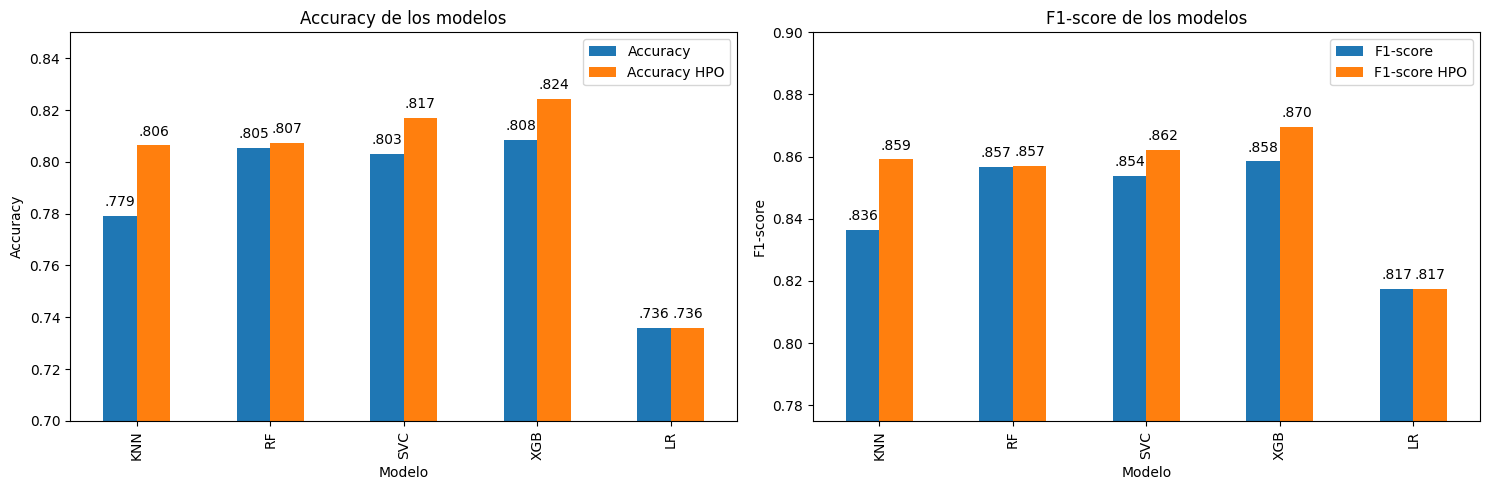

In [281]:
# Graficaremos ahora los resultados de los modelos con los hiperparámetros ajustados y los hiperparámetros por defecto

# Accuracy
accuracy = [accuracy_knn, accuracy_rf, accuracy_svc, accuracy_xgb, accuracy_lr]
accuracy_hpo = [accuracy_knn_hpo, accuracy_rf_hpo, accuracy_svc_hpo, accuracy_xgb_hpo, accuracy_lr]

# F1-score
f1 = [f1_knn, f1_rf, f1_svc, f1_xgb, f1_lr]
f1_hpo = [f1_knn_hpo, f1_rf_hpo, f1_svc_hpo, f1_xgb_hpo, f1_lr]

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Accuracy': accuracy,
    'Accuracy HPO': accuracy_hpo,
    'F1-score': f1,
    'F1-score HPO': f1_hpo
}, index=['KNN', 'RF', 'SVC', 'XGB', 'LR'])

# Graficar los resultados
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

results[['Accuracy', 'Accuracy HPO']].plot(kind='bar', ax=axs[0])
axs[0].set_title('Accuracy de los modelos')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Modelo')
axs[0].set_ylim([0.7, 0.85])

# Agrega etiquetas de valor a las barras
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.3f').lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

results[['F1-score', 'F1-score HPO']].plot(kind='bar', ax=axs[1])
axs[1].set_title('F1-score de los modelos')
axs[1].set_ylabel('F1-score')
axs[1].set_xlabel('Modelo')
axs[1].set_ylim([0.775, 0.9])

# Agrega etiquetas de valor a las barras
for p in axs[1].patches:
    axs[1].annotate(format(p.get_height(), '.3f').lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [282]:
# entrenar XGBoost con los mejores hiperparametros encontrados y todos los datos
best_model = XGBClassifier(**best_params_xgb, random_state=SEED)

pipe_xgb = Pipeline([
    ('preproceso', standard),
    ('clasificador', best_model)
])

pipe_xgb.fit(X, y)

# exportar el modelo en un archivo pickle
import pickle

with open('model_clasificacion.pkl', 'wb') as file:
    pickle.dump(pipe_xgb, file)

/home/beto/Documents/GitHub/Aprendizaje-automatico/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "clasificador__learning_rate", "clasificador__max_depth", "clasificador__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
